In [2]:
#!/usr/bin/python3
import os, cv2 #,matplotlib; matplotlib.use('Agg')
from pylab import * # import matplotlib & numpy

# Create Normalized Curve:
def Curve(tp, p, t): # normalized curve
    s1 = p[2] * np.sin((p[0]*t+p[1])*np.pi);
    s2 = p[5] * np.sin((p[3]*t+p[4])*np.pi); no = 0; # noise
    if type(tp) != str: # add extra noise when tp<0 for "sps"
        no, tp = int(tp<0)*(np.random.rand(len(t))-0.5)/5, "sps";
    if "sps" in tp: return (s1 + s2)/(abs(p[2]) + abs(p[5])) + no
    if "sms" in tp: return (s1 * s2)/(abs(p[2]) * abs(p[5])) + no
    if len(p)>=9: s3 = p[8] * np.sin((p[6]*t+p[7])*np.pi)
    if "sss" in tp: return (s1 + s2 + s3)/(abs(p[2])+abs(p[5])+abs(p[8])) + no

# Get Random [linewidth, alpha] Pairs:
def LwAl(n=1, tp=1, dx=180): # random [linewidth, alpha] pair
    wa = np.random.rand(2*n); f = int(abs(tp)<5)*(dx/180-1)+1;
    wa[::2] = [round(f*(i+2),1) for i in wa[::2]] # linewidth
    wa[1::2] = [round(0.4*i+0.4,2) for i in wa[1::2]] # alpha
    if abs(tp) in (4,8): wa[::2] = round(1.2*f,1); # for tp=4
    return wa # type: np.array

# Rotate or Affine the Curve:
def RoAf(t, y, ra=0, af=None): # rotate or affine the curve
    if type(ra) != np.ndarray: # rotational angle -> matrix
        ra *= np.pi; ra = np.array([[cos(ra),-sin(ra)],[sin(ra),cos(ra)]])
    if type(af) == np.ndarray:   ra = ra.dot(af); # affine & rotate
    y = ra.dot(np.array([t,y])); # rotate/affine the curve
    return y[0,:], y[1,:] # t'=y[0,:], y'=y[1,:]

# Draw Curve with Annotation:
def DrawCu(tp, p=None, xi=0, dx=20, yo=0, A=1, ra=0, af=0, wa=[]): # draw curve
    if p==None or len(p)<6: # get curve parameters
        p = [round(2*i,2) for i in np.random.rand(9)]; p[2]=p[5]=p[8]=1
    t = np.linspace(xi, xi+2*dx, round(2*dx*(np.random.rand()+1)), endpoint=True);
    y = A * (Curve(tp,p,t) + yo); # vertically scale + translate
    t,y = RoAf(t-(xi+dx), y, ra, af); # horizontally adjust -> rotate/affine

    if len(wa)<2: wa = LwAl(1,tp,dx); # get [linewidth,alpha] pair
    an = str(tp)+": "+", ".join([str(i) for i in p])+"->"+", ".join([str(i) for i in wa])
    plot(t, y, color="k", lw=wa[0], alpha=wa[-1], label=an);
    return t, y, wa, p

In [3]:
# Extract sps Cell Parameters:
def Paras(tp, dx, A, f): # Extract sps Cell Parameters
    tp = abs(tp); # add noise when tp<0
    if tp>4: tp -= 4; dx = 180; # keep sps Cell size
    yf = dx/180; # Cell Ratio: Amplitude scale as image width
    if tp==1: # Reticulate Pattern Type1
        A = 42*yf; f = 12/dx; p = [0.2*f, 3/8, 0.5, 0.8*f, 0, 0.8]
    elif tp==2: # Reticulate Pattern Type2
        A = 30*yf; f = 8/dx; p = [0.2*f, 3/8, 0.5, 0.8*f, 0, 0.75]
    elif tp==3: # Reticulate Pattern Type3
        A = 55*yf; f = 8/dx; p = [0.2*f, 3/8, 0.5, 0.8*f, 0, 0.8]
        f = np.array([[1,-0.5],[-0.15,1]]); # Affine Matrix for Type3
    elif tp==4: # Reticulate Pattern Type4
        A = 10*yf; f = 7.5/dx; p = [0.2*f, 3/8, 0.5, 0.8*f, 0, 0.8]
        f = np.array([[1.15,1.1],[-0.45,0.7]]); # Affine Matrix for Type4
    else: A *= yf; f /= dx; p = [0.2*f, 3/8, 0.5, 0.8*f, 0, 0.8-tp%0.2]
    return A, p, f

# Draw Reticulate Pattern Cell(sps):
def DrawCel(dx, yi=0, tp=1, ra=0, wa=[], A=42, f=12): # draw sps cell
    xi = round(dx*np.random.rand(),1);
    dy = round(0.2+(np.random.rand()-0.5)/10, 3);
    A,p1,f = Paras(tp,dx,A,f); # get sps Cell Parameters
    p2 = p1.copy(); p2[::-3] = [-i for i in p2[::-3]]
    
    t = np.linspace(xi, xi+2*dx, round(2*dx*(np.random.rand()+1)), endpoint=True);
    y1 = A * (Curve(tp,p1,t) + (yi+dy)); # vertically scale + trans
    y2 = A * (Curve(tp,p2,t) + (yi-dy)); # vertically scale + trans
    t -= xi+dx; t1,y1 = RoAf(t,y1,ra,f); t2,y2 = RoAf(t,y2,ra,f) # rotate/affine
    plot(t1, y1, color="b", lw=wa[0], alpha=wa[-1])
    plot(t2, y2, color="b", lw=wa[2], alpha=wa[-1])
    return [t1,y1, t2,y2]

# Draw Reticulate Pattern Cell(sps):
def DrawCell(dx, yi=0, tp=1, ra=0, wa=[], A=42, f=12): # draw sps cell
    xi = round(dx*np.random.rand(),1);
    dy = round(0.2+(np.random.rand()-0.5)/10, 3);
    A,p1,f = Paras(tp,dx,A,f); # get sps Cell Parameters
    p2 = p1.copy(); p2[::-3] = [-i for i in p2[::-3]]
    t1,y1,w1,p1 = DrawCu(tp, p1, xi, dx, yi+dy, A, ra, f, wa=wa[:])
    t2,y2,w2,p2 = DrawCu(tp, p2, xi, dx, yi-dy, A, ra, f, wa=wa[2:])
    return [t1,y1, t2,y2]

# Add Reticulate Net to Image:
def Add2Im(im, tp=None, ro=None, wa=None, gap=1.6, fun=DrawCell): # add to image
    if type(im)==str: im = imread(im) # load image
    n = im.shape; y,x = n[0],n[1]; n = y//20; # width & height
    if tp==None: tp = np.random.randint(-8,9); print("tp =",tp)
    if ro==None: ro = 2*np.random.rand()-1; # randomly rotate
    if wa==None or len(wa)<4: wa = LwAl(2,tp,x); # [lw,alpha]
    ofs = round(1.5*np.random.rand(), 2);
    gap = round(gap+(np.random.rand()-0.3)/10, 2); net = [];
    for i in range(2*n): net += fun(x, gap*(i-n)+ofs, tp, ro, wa=wa)
    subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)
    imshow(im, extent=(-x/2,x/2,-y/2,y/2)); axis("off"); xticks([]); yticks([]);
    return net

# Save Image with Reticulate Net:
def Save2Im(im, out, tp=None, ro=None, wa=None, gap=1.6, ms=None):
    if type(im)==str: im = imread(im) # load image
    dpi = 72; n = im.shape; y,x = n[0],n[1]; # width & height
    figure(figsize=(x/dpi, y/dpi), dpi=dpi); # set figsize
    net = Add2Im(im, tp, ro, wa, gap); savefig(out, dpi=dpi);
    if ms != None: # output mask image
        if type(ms) != str: ms = "./Test/blank.png";
        imshow(imread(ms), extent=(-x/2,x/2,-y/2,y/2));
        out = out[:-4]+"_m.png"; savefig(out); im = cv2.imread(out, 0);
        ret,im = cv2.threshold(im, 250, 255, cv2.THRESH_BINARY_INV);
        cv2.imwrite(out, im, [int(cv2.IMWRITE_PXM_BINARY),1]);
    close("all"); return net

# Save Image with Reticulate Net:
def SaveIm(im, out, tp=None, ro=None, wa=None, gap=1.6, ms=None):
    if type(im)==str: im = imread(im) # load image
    n = im.shape; y,x = n[0],n[1]; n = y//20; # width & height
    if tp==None: tp = np.random.randint(-8,9); print("tp =",tp)
    if ro==None: ro = 2*np.random.rand()-1; # randomly rotate
    if wa==None or len(wa)<4: wa = LwAl(2,tp,x); # [lw,alpha]
    ofs = round(1.5*np.random.rand(), 2);
    gap = round(gap+(np.random.rand()-0.3)/10, 2); net = [];
    dpi = 72; figure(figsize=(x/dpi, y/dpi), dpi=dpi); axis("off");
    subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)
    for i in range(2*n): net += DrawCell(x, gap*(i-n)+ofs, tp, ro, wa=wa)
    
    if ms != None: # output mask image
        xlim(-x/2,x/2); ylim(-y/2,y/2); ms = out[:-4]+"_m.png";
        savefig(ms, facecolor="w", dpi=dpi); tp = cv2.imread(ms, 0);
        gap,tp = cv2.threshold(tp, 250, 255, cv2.THRESH_BINARY_INV);
        cv2.imwrite(ms, tp, [int(cv2.IMWRITE_PXM_BINARY),1]);
    imshow(im, extent=(-x/2,x/2,-y/2,y/2)); savefig(out, dpi=dpi);
    close("all"); return net

# Batch to Save Images with Reticulate Net:
def Batch_SaveIm(org, tp=range(5,9), num=None, ms=None):
    out = lambda name,k: name[:-4]+"_"+str(k)+".jpg";
    if org[-1] != "/": org += "/"; # original image path
    dst = org.split("/"); dst[-2] += "2"; dst = "/".join(dst)
    if not os.path.exists(dst): os.mkdir(dst); # dst dir
    for i in os.listdir(org)[:1]: # loop subdirs of org dir
        if not os.path.exists(dst+i): os.mkdir(dst+i); # dst subdir
        os.chdir(dst+i); outlist = os.listdir(dst+i); # pwd = dst+i
        for im in os.listdir(org+i): # loop images in org subdir
            if num == None: tps = tp; # loop for all types
            else: tps = np.random.randint(tp.start, tp.stop, num);
            tps = [k for k in set(tps) if out(im,k) not in outlist]
            for k in tps: SaveIm(org+i+"/"+im, out(im,k), tp=k, ms=ms);

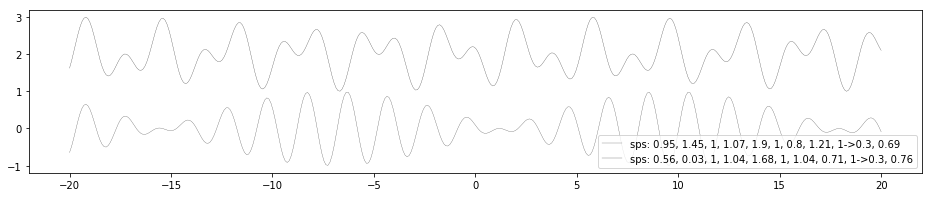

In [53]:
# Random search paras:
figure(figsize=(16,3))
DrawCu("sps",yo=0); DrawCu("sps",yo=2);
legend(loc='lower right'); show()

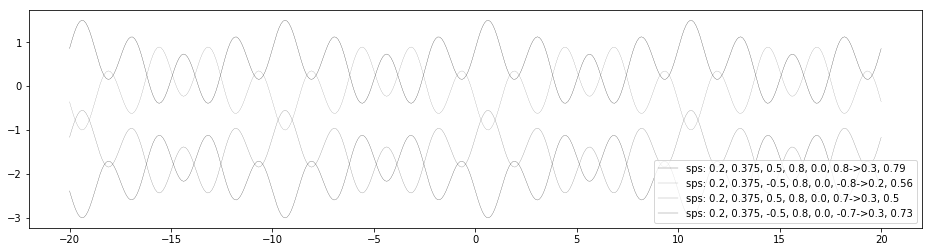

In [55]:
# Finetune paras of sps:
figure(figsize=(16,4))
#p = [0.1, 0.5, 5, 1, 0.0, 2]; DrawCu("sps", p, yo=2)
#p = [0.05, 0.5, 1, 0.8, 0.0, 2]; DrawCu("sps", p, yo=0)
#p = [0.1, 0.5, 1, 1.0, 0.0, 0.5]; DrawCu("sps", p, yo=2)
#p = [0.1, 0.0, 1, 0.5, 0.0, 1]; DrawCu("sps", p, yo=0)
#p = [0.1, 0.0, 1, 0.7, 0.0, 1]; DrawCu("sps", p, yo=2)
#p = [0.1, 0.0, 1, 0.7, 0.0, 0.4]; DrawCu("sps", p, yo=0)

#p = [1.1, 0.0, 1, 0.8, 0.05, 1]; DrawCu("sps", p, yo=2)
#p = [0.6, 0.5, 1, 0.75, 1.0, 1]; DrawCu("sps", p, yo=0)
#p = [0.25, 0.7, 1, 0.5, 0.9, 1]; DrawCu("sps", p, yo=2)
#p = [0.25, 0.25, 1, 1.0, -0.5, 1]; DrawCu("sps", p, yo=0)
#p = [0.25, 0.25, 1, 1.0, 0.5, 1]; DrawCu("sps", p, yo=2)
#p = [0.5, 0.0, 1, 0.3, 0.0, 1]; DrawCu("sps", p, yo=0)
#p = [0.5, 0.0, 1, 0.7, 0.0, 1]; DrawCu("sps", p, yo=2)
#p = [0.6, 0.0, 1, 1.0, 0.0, 1]; DrawCu("sps", p, yo=0)
#p = [1.0, 0.0, 1, 1.2, 0.5, 1]; DrawCu("sps", p, yo=2)
#p = [0.8, 0.0, 1, 1.0, 0.63, 1]; DrawCu("sps", p, yo=0)
#p = [0.8, 0.0, 1, 1.2, 0.75, 1]; DrawCu("sps", p, yo=2)
#p = [1.5, 0.5, 1, 1.8, 1.5, 1]; DrawCu("sps", p, yo=0)

#p = [0.8, 1.5, 0.5, 1.0, 0.5, 1.5]; DrawCu("sps", p, yo=2)
#p = [0.8, 0.5, 0.4, 0.3, 0.0, 0.4]; DrawCu("sps", p, yo=0)

#p = [0.1, 3/8, 1, 0.4, 0.0, 1]; DrawCu("sps", p, yo=2)
#p = [0.2, 3/8, 1, 0.8, 0.0, 1]; DrawCu("sps", p, yo=0) # Good
#p = [0.2, 3/8, 0.5, 0.8, 0.0, 0.8]; DrawCu("sps", p, yo=0) # Good
p = [0.2, 3/8, 0.5, 0.8, 0.0, 0.8]; DrawCu("sps", p, yo=0.5) # Good
p = [0.2, 3/8, -0.5, 0.8, 0.0, -0.8]; DrawCu("sps", p, yo=0) # Good
p = [0.2, 3/8, 0.5, 0.8, 0.0, 0.7]; DrawCu("sps", p, yo=-1.55) # Good
p = [0.2, 3/8, -0.5, 0.8, 0.0, -0.7]; DrawCu("sps", p, yo=-2) # Good
legend(loc='lower right'); show()

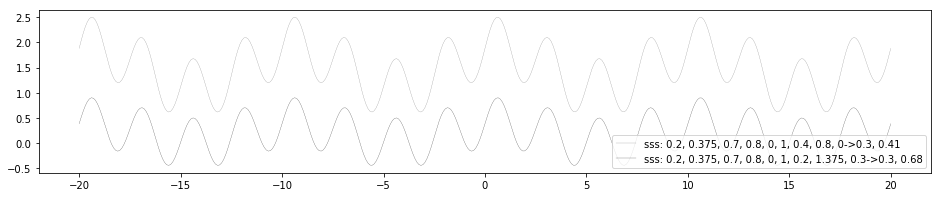

In [58]:
# Finetune paras of sss:
figure(figsize=(16,3))
#p = [1.0, 0.0, 1, 1.2, 0.5, 1, 0.05, 0.0, 0.2]; DrawCu("sss", p, yo=2)
#p = [1.0, 0.0, 1, 1.2, 0.5, 1, 0.05, 0.35, 1]; DrawCu("sss", p, yo=0)
#p = [1.0, 0.0, 1, 1.2, 1.5, 0.3, 0.02, 0.35, 0.6]; DrawCu("sss", p, yo=2)
p = [0.2, 3/8, 0.7, 0.8, 0, 1, 0.4, 0.8, 0]; DrawCu("sss", p, yo=1.5)
p = [0.2, 3/8, 0.7, 0.8, 0, 1, 0.2, 11/8, 0.3]; DrawCu("sss", p, yo=0.2)
#p = [0.2, 3/8, -0.7, 0.8, 0, -1, 0.2, 11/8, -0.3]; DrawCu("sss", p, yo=0)
legend(loc='lower right'); show()

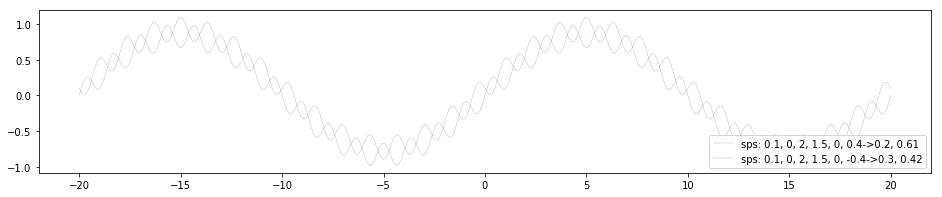

In [59]:
# Search paras for Type3:
figure(figsize=(16,3))
p = [0.1, 0, 2, 1.5, 0, 0.4]; DrawCu("sps", p, yo=0)
p = [0.1, 0, 2, 1.5, 0, -0.4]; DrawCu("sps", p, yo=0.1)
legend(loc='lower right'); show()

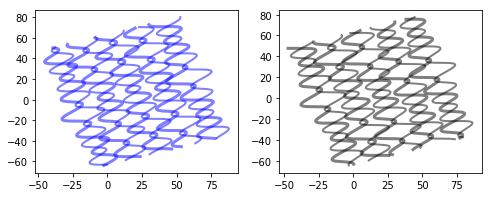

In [78]:
# Test Rotations:
figure(figsize=(8,3)); wa = [3,0.4, 2,0.5];
subplot(1,2,1);
for i in range(5): DrawCel(60, (i-3)*1.5, 0, 0.6, wa, f=8)
subplot(1,2,2);
for i in range(5): DrawCell(60, (i-3)*1.5, 0, 0.6, wa, f=8)
show()

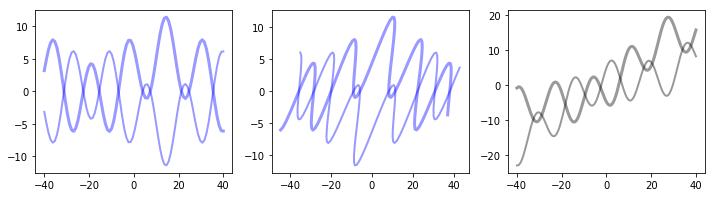

In [376]:
# Test Affine:
figure(figsize=(12,3)); wa = [3,0.4, 2,0.4];
ro = np.array([[1,0],[0,1]]);
af1 = np.array([[1,0.8],[0,1]]);
af2 = np.array([[1,0],[0.3,1]]);
subplot(1,3,1); DrawCel(40, 0, 0, ro, wa, f=6);
subplot(1,3,2); DrawCel(40, 0, 0, af1, wa, f=6);
subplot(1,3,3); DrawCell(40, 0, 0, af2, wa, f=6);
show()

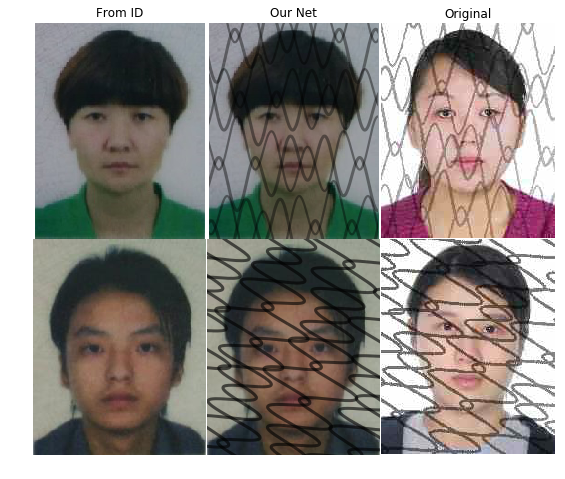

In [8]:
# Test Type1:
figure(figsize=(7.25,6))

wa = [2.2,0.4, 3,0.4];
im = imread("./Test/111.jpg");
im2 = imread("./Test/N1.1.jpg");
subplot(2,3,1); imshow(im); axis("off"); title("From ID");
subplot(2,3,2); Add2Im(im, tp=1, ro=0.0, wa=wa); title("Our Net");
subplot(2,3,3); imshow(im2); axis("off"); title("Original");

wa = [3,0.6, 3,0.6];
im = imread("./Test/222.jpg");
im2 = imread("./Test/N1.2.jpg");
subplot(2,3,4); imshow(im); axis("off");
subplot(2,3,5); Add2Im(im, tp=1, ro=0.4, wa=wa);
subplot(2,3,6); imshow(im2); axis("off");

savefig("./Test/out1.jpg"); show()

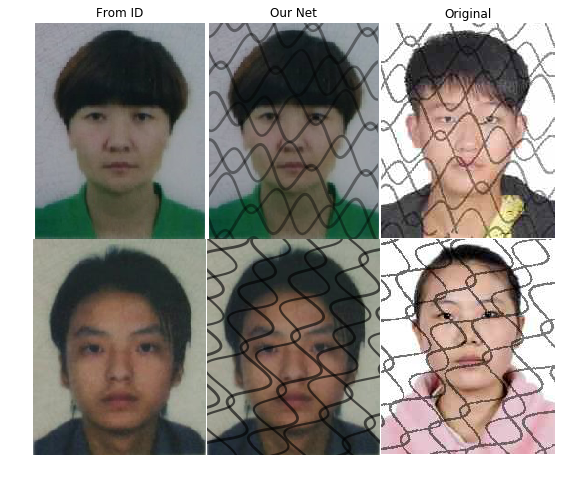

In [9]:
# Test Type2:
figure(figsize=(7.25,6))

wa = [2.5,0.5, 3,0.4];
im = imread("./Test/111.jpg");
im2 = imread("./Test/N2.1.jpg");
subplot(2,3,1); imshow(im); axis("off"); title("From ID");
subplot(2,3,2); Add2Im(im, tp=2, ro=-0.03, wa=wa, gap=1.6); title("Our Net");
subplot(2,3,3); imshow(im2); axis("off"); title("Original");

wa = [2.2,0.7, 2.8,0.6];
im = imread("./Test/222.jpg");
im2 = imread("./Test/N2.4.jpg");
subplot(2,3,4); imshow(im); axis("off");
subplot(2,3,5); Add2Im(im, tp=2, ro=0.42, wa=wa, gap=1.6);
subplot(2,3,6); imshow(im2); axis("off");

savefig("./Test/out2.jpg"); show()

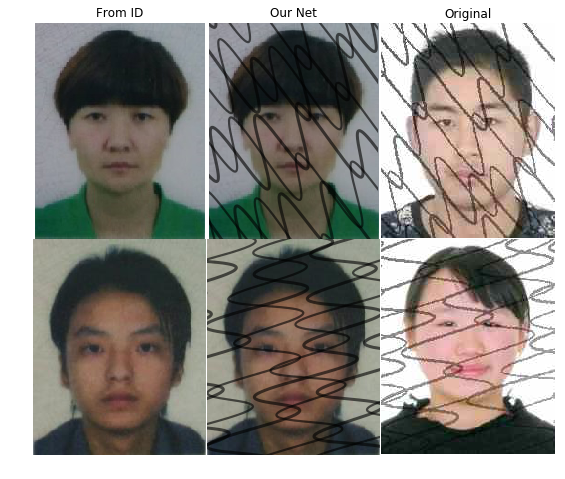

In [19]:
# Test Type3:
figure(figsize=(7.25,6));

wa = [3,0.6, 2.2,0.6];
im = imread("./Test/111.jpg");
im2 = imread("./Test/N3.6.jpg");
subplot(2,3,1); imshow(im); axis("off"); title("From ID");
subplot(2,3,2); Add2Im(im, tp=3, ro=0, wa=wa, gap=1.6); title("Our Net");
subplot(2,3,3); imshow(im2); axis("off"); title("Original");

im = imread("./Test/222.jpg");
im2 = imread("./Test/N3.1.jpg");
subplot(2,3,4); imshow(im); axis("off");
subplot(2,3,5); Add2Im(im, tp=3, ro=0.39, wa=wa, gap=1.55);
subplot(2,3,6); imshow(im2); axis("off");

savefig("./Test/out3.jpg"); show()

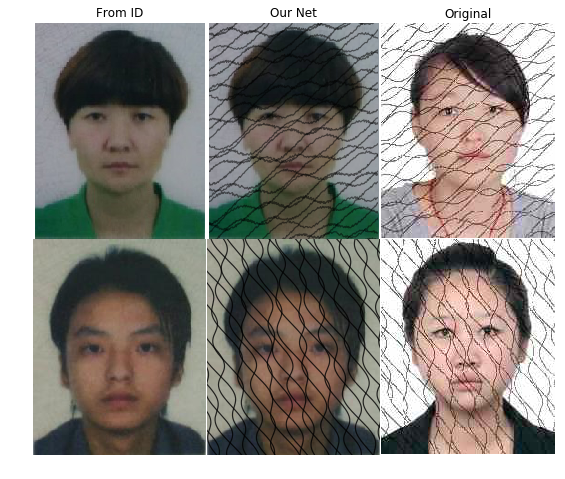

In [11]:
# Test Type4:
figure(figsize=(7.25,6));

im = imread("./Test/111.jpg");
im2 = imread("./Test/N4.2.jpg");
subplot(2,3,1); imshow(im); axis("off"); title("From ID");
subplot(2,3,2); Add2Im(im, tp=-8, ro=0.25, gap=1.6); title("Our Net");
subplot(2,3,3); imshow(im2); axis("off"); title("Original");
im = imread("./Test/222.jpg");
im2 = imread("./Test/N4.4.jpg");
subplot(2,3,4); imshow(im); axis("off");
subplot(2,3,5); Add2Im(im, tp=8, ro=-0.26, gap=1.7);
subplot(2,3,6); imshow(im2); axis("off");

savefig("./Test/out4.jpg"); show()

In [4]:
# Test Save2Im:
org = "./FacePic/WebFace";
Batch_SaveIm(org, num=2)

In [11]:
im = cv2.imread("./Test/000.jpg");
cv2.imshow("test",im); cv2.waitKey(0); im.shape
for i,j in zip("dsadsa","huje"): print(i,j)

d h
s u
a j
d e
